In [10]:
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import altair as alt

In [11]:
def timedelta_to_seconds(delta: timedelta):
    total_seconds = delta.total_seconds()
    total_microseconds = delta.microseconds
    return total_seconds + (total_microseconds / 1000000)

def extract_times(time: datetime):
    return time.hour, time.minute, time.second

def calc_speed(lat1, lng1, lat2, lng2, time):
    delta_lat = lat2 - lat1
    delta_lng = lng2 - lng1
    a = (np.sin(delta_lat / 2) ** 2) + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lng / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = 6371 * c # haversine distance
    return distance / (time + 1e-9) # add small number to avoid division by zero

def deviation(ais_msg) -> float:
    hour_rec, min_rec, sec_rec = extract_times(ais_msg['recorded'])
    hour_gen, min_gen, sec_gen = extract_times(ais_msg['generated'])
    return (hour_rec * 3600 + min_rec * 60 + sec_rec) - (hour_gen * 3600 + min_gen * 60 + sec_gen) 

In [12]:
def partition(D, threshold_partition):
    breakpts = [0]
    for i in range(1, len(D)):
        lat1, lng1 = D.iloc[i - 1]['LAT'], D.iloc[i - 1]['LON']
        lat2, lng2 = D.iloc[i]['LAT'], D.iloc[i]['LON']
        speed = calc_speed(lat1, lng1, lat2, lng2, timedelta_to_seconds(D.iloc[i]['BaseDateTime'] - D.iloc[i - 1]['BaseDateTime']))
        difference = abs(speed - D.iloc[i]['SOG']) #TODO allow also using deviation

        if difference > threshold_partition:
            breakpts.append(i)
        
    # split D into subtracks at the breakpoints
    subtracks = []
    for i in range(len(breakpts)):
        if i == 0:
            subtracks.append(D.iloc[:breakpts[i]])
        else:
            subtracks.append(D.iloc[breakpts[i - 1]:breakpts[i]])
    subtracks.append(D.iloc[breakpts[-1]:])
    return subtracks

In [13]:
def association(tracks, threshold_association, threshold_completeness):
    result = []
    while len(tracks) > 0:
        boat = []
        M = tracks[0]
        # tracks.remove(M)
        del tracks[0]
        if len(M) == 0:
            continue
        boat.append(M)
        if len(tracks) == 0:
            break
        for i, N in enumerate(tracks):
            # Calculate association_value based on the first point in track and the last point in boat
            # association_value depends on data type. Space data: Difference between the recorded speed of the
            # first point in track and calculated speed based on positions and time, 
            # The time deviation: Difference of the time deviations.
            association_value = tracks[0].iloc[0]['SOG'] - calc_speed(
                boat[-1].iloc[-1]['LAT'], boat[-1].iloc[-1]['LON'], 
                N.iloc[0]['LAT'], N.iloc[0]['LON'], 
                timedelta_to_seconds(N.iloc[0]['BaseDateTime'] - boat[-1].iloc[-1]['BaseDateTime'])
            )
            if association_value <= threshold_association:
                boat.append(N)
                # tracks.remove(N)
                del tracks[i]
        # filtering of pysical integrity
        final_df = pd.concat(objs=boat)
        if len(final_df) > threshold_completeness:
            result.append(final_df)
    return result

In [14]:
data=pd.read_csv("AIS_2022_01_01.csv", delimiter=",", encoding='utf-8', on_bad_lines="skip", header=0, parse_dates=['BaseDateTime'])
data.head()

MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  368084090 2022-01-01 00:00:00  29.93174 -89.99243  6.0  296.2    299.0   
1  368140160 2022-01-01 00:00:00  30.33475 -87.14429  0.0  312.0     87.0   
2  366941830 2022-01-01 00:00:02  29.30919 -94.79702  0.0  180.2    511.0   
3  316005971 2022-01-01 00:00:06  46.50268 -84.35674  2.4  258.6    257.0   
4  316004054 2022-01-01 00:00:07  46.50326 -84.37506  0.3   61.9    511.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  LARRY B WHIPPLE         NaN  WDK7401        57.0    12.0    23.0   10.0   
1    TWISTED ANGEL  IMO0000000  WDL5339        36.0     NaN    12.0    7.0   
2     SAN PATRICIO         NaN  WCX6675        31.0     5.0    18.0    7.0   
3      BEVERLY M I  IMO9084047  CFP2004        31.0     0.0    34.0   10.0   
4       ADANAC III  IMO8745333     VCLT        31.0     0.0    24.0    5.0   

   Draft  Cargo TransceiverClass  
0    3.0   57.0                A  
1    NaN    NaN                B  
2    NaN   57.0                A  
3    5.3   99.0                A  
4    3.0   50.0                A

In [15]:
len(data)

7239758

In [16]:
group = data.groupby("MMSI")

In [ ]:
i = 0
for g in group:
    if i == 1: break
    print(g)
    print('--------------')
    print(len(g[1]))
    print(g[1].columns)
    print(g[1]['MMSI'])
    print(g[1].index)
    i += 1


## Plot showing a single track without sorting data points

1212 1212


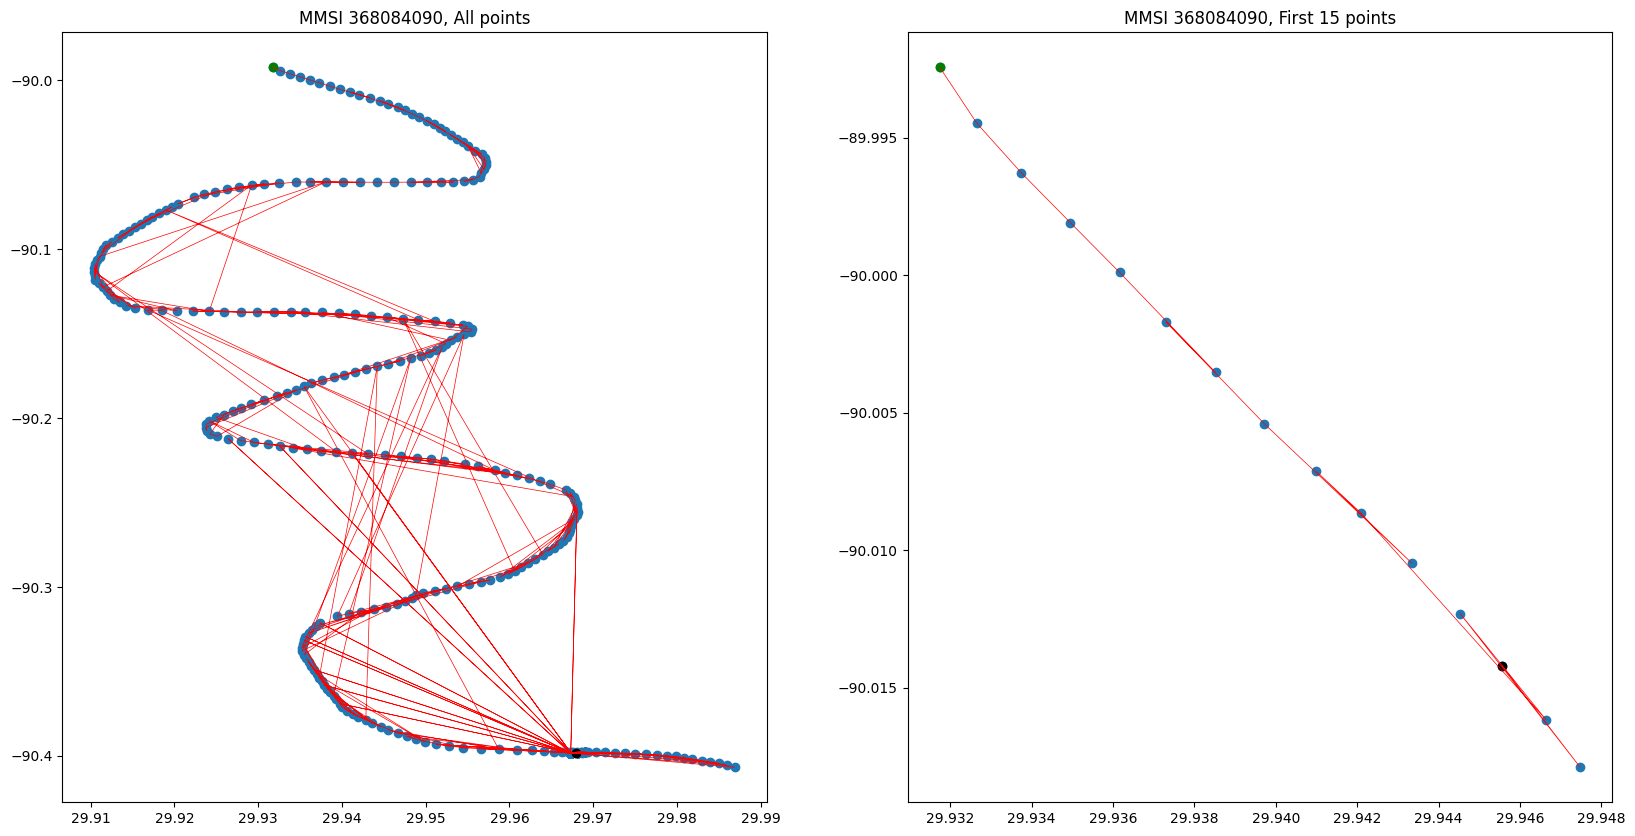

In [12]:
mmsi = 368084090
a = group.get_group(mmsi)
lats = a["LAT"].values
lons = a["LON"].values

print(len(lats), len(lons))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].set_title(f"MMSI {mmsi}, All points")
ax[0].scatter(lats, lons)
ax[0].scatter(lats[-1:], lons[-1:], color="black")
ax[0].scatter(lats[:1], lons[:1], color="green")
ax[0].plot(lats, lons, color="red", linewidth=0.5)
ax[1].set_title(f"MMSI {mmsi}, First 15 points")
ax[1].scatter(lats[:15], lons[:15])
ax[1].scatter(lats[:15][-1:], lons[:15][-1:], color="black")
ax[1].scatter(lats[:15][:1], lons[:15][:1], color="green")
ax[1].plot(lats[:15], lons[:15], color="red", linewidth=0.5)
plt.show()

#### Sort the data

In [17]:
group2 = data.sort_values(['BaseDateTime'],ascending=True).groupby("MMSI")

## Plot shwoing a single track with sorted data points

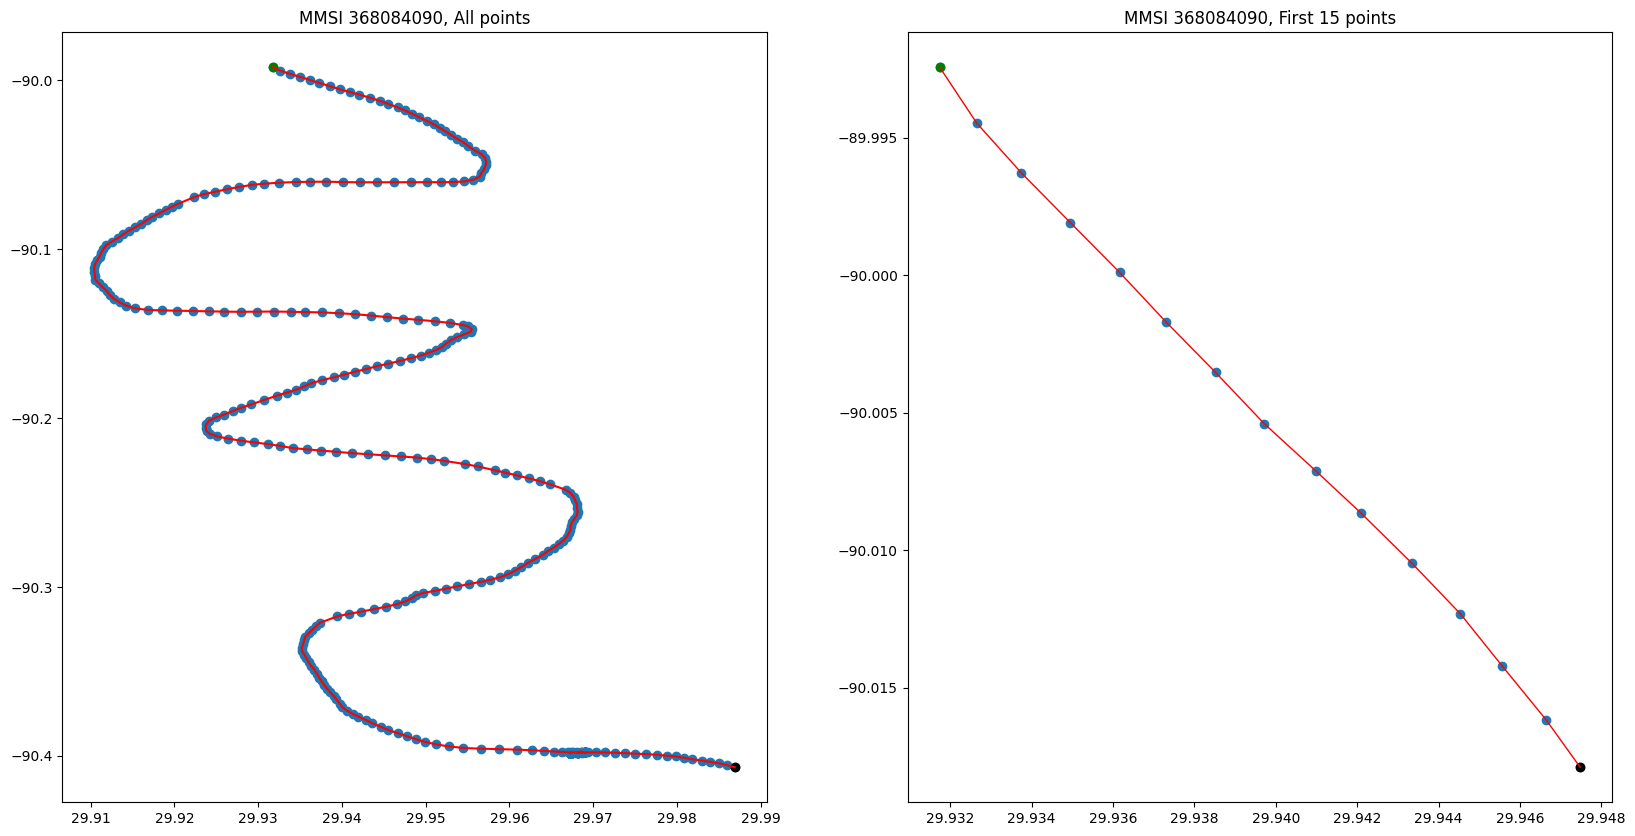

In [14]:
a = group2.get_group(mmsi)
lats = a["LAT"].values
lons = a["LON"].values

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].set_title(f"MMSI {mmsi}, All points")
ax[0].scatter(lats, lons)
ax[0].scatter(lats[-1:], lons[-1:], color="black")
ax[0].scatter(lats[:1], lons[:1], color="green")
ax[0].plot(lats, lons, color="red", linewidth=1.5)
ax[1].set_title(f"MMSI {mmsi}, First 15 points")
ax[1].scatter(lats[:15], lons[:15])
ax[1].scatter(lats[:15][-1:], lons[:15][-1:], color="black")
ax[1].scatter(lats[:15][:1], lons[:15][:1], color="green")
ax[1].plot(lats[:15], lons[:15], color="red", linewidth=1)
plt.show()

## Plot showing the same plot with unsorted and sorted data points

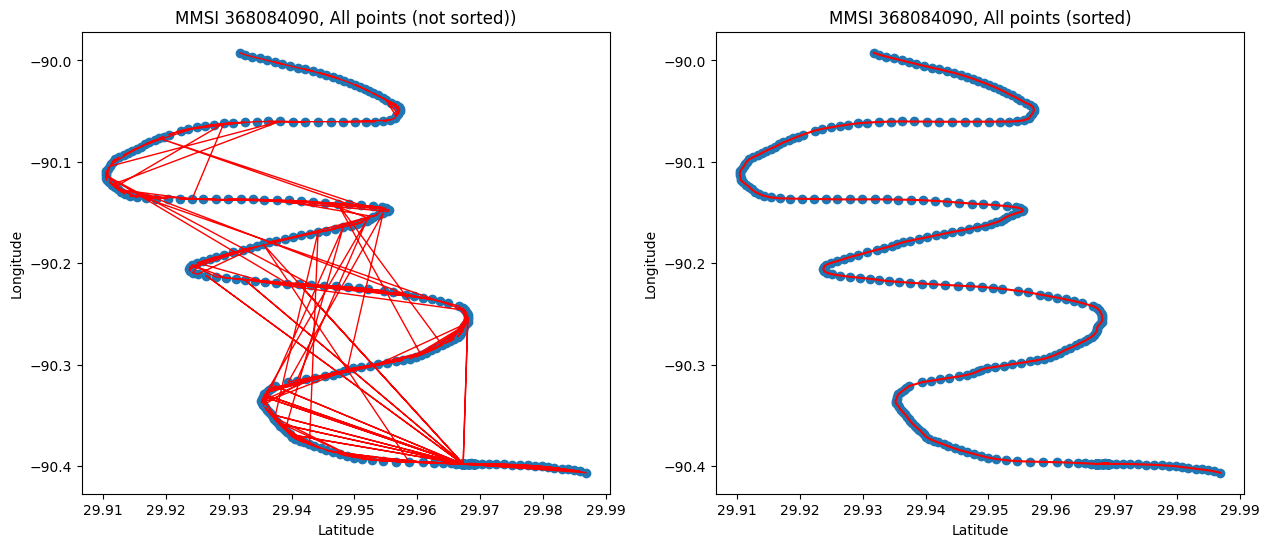

In [15]:
a = group.get_group(mmsi)
lats = a["LAT"].values
lons = a["LON"].values

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].set_title(f"MMSI {mmsi}, All points (not sorted))")
ax[0].scatter(lats, lons)
ax[0].plot(lats, lons, color="red", linewidth=1)
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Longitude")

a = group2.get_group(mmsi)
lats = a["LAT"].values
lons = a["LON"].values
ax[1].set_title(f"MMSI {mmsi}, All points (sorted)")
ax[1].scatter(lats, lons)
ax[1].plot(lats, lons, color="red", linewidth=1.5)
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Longitude")
plt.show()

## Plot showing a single track with segmentation

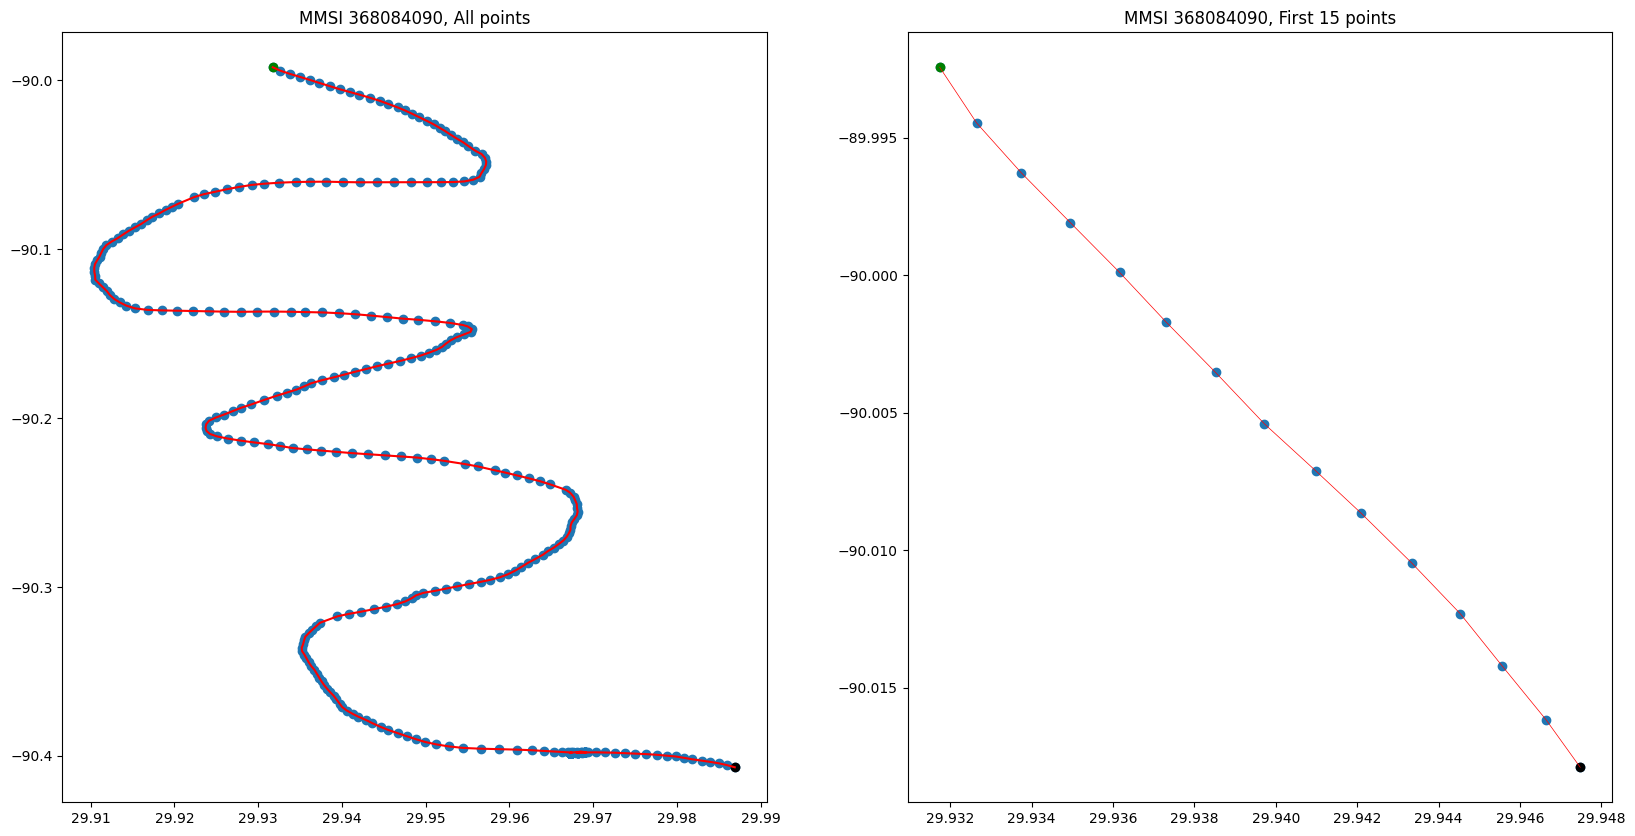

In [16]:
dates = group2.get_group(mmsi)["BaseDateTime"].values

for i in range(len(dates)):
    if i > 0:
        if dates[i - 1] > dates[i]:
            print(f"{dates[i - 1]} > {dates[i]}")

subtracks = partition(group2.get_group(mmsi), 15)

# plot subtracks, all points and first 15 points
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].set_title(f"MMSI {mmsi}, All points")
ax[0].scatter(lats, lons)
ax[0].scatter(lats[-1:], lons[-1:], color="black")
ax[0].scatter(lats[:1], lons[:1], color="green")
for subtrack in subtracks:
    ax[0].plot(subtrack['LAT'], subtrack['LON'], color="red", linewidth=1.5)
ax[1].set_title(f"MMSI {mmsi}, First 15 points")
ax[1].scatter(lats[:15], lons[:15])
ax[1].scatter(lats[:15][-1:], lons[:15][-1:], color="black")
ax[1].scatter(lats[:15][:1], lons[:15][:1], color="green")
for subtrack in subtracks:
    ax[1].plot(subtrack['LAT'][:15], subtrack['LON'][:15], color="red", linewidth=0.5)
plt.show()

## Plot showing all tracks with and without sorting data points

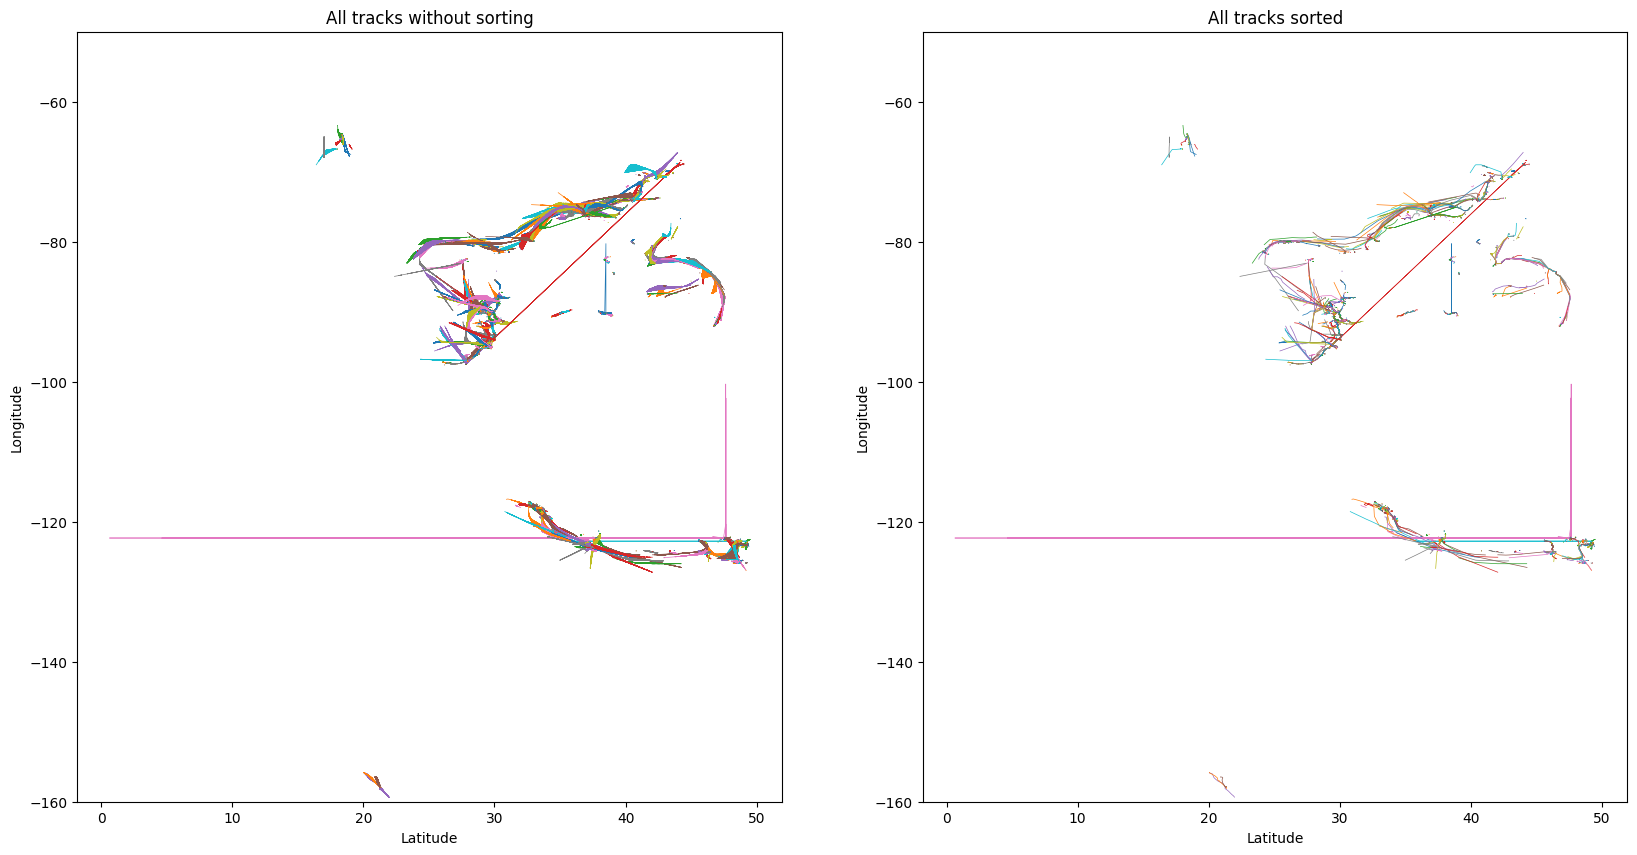

In [18]:
mmsis = []

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].set_ylim(-160, -50)
ax[1].set_ylim(-160, -50)
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Longitude")
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Longitude")
ax[0].set_title("All tracks without sorting")
ax[1].set_title("All tracks sorted")

for g in group:
    if len(g[1]) > 1000:
        mmsis.append(g[0])
        ax[0].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
for g in group2:
    if len(g[1]) > 1000:
        ax[1].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
plt.show()

## Plot showing subarea of all tracks with and without sorting data points

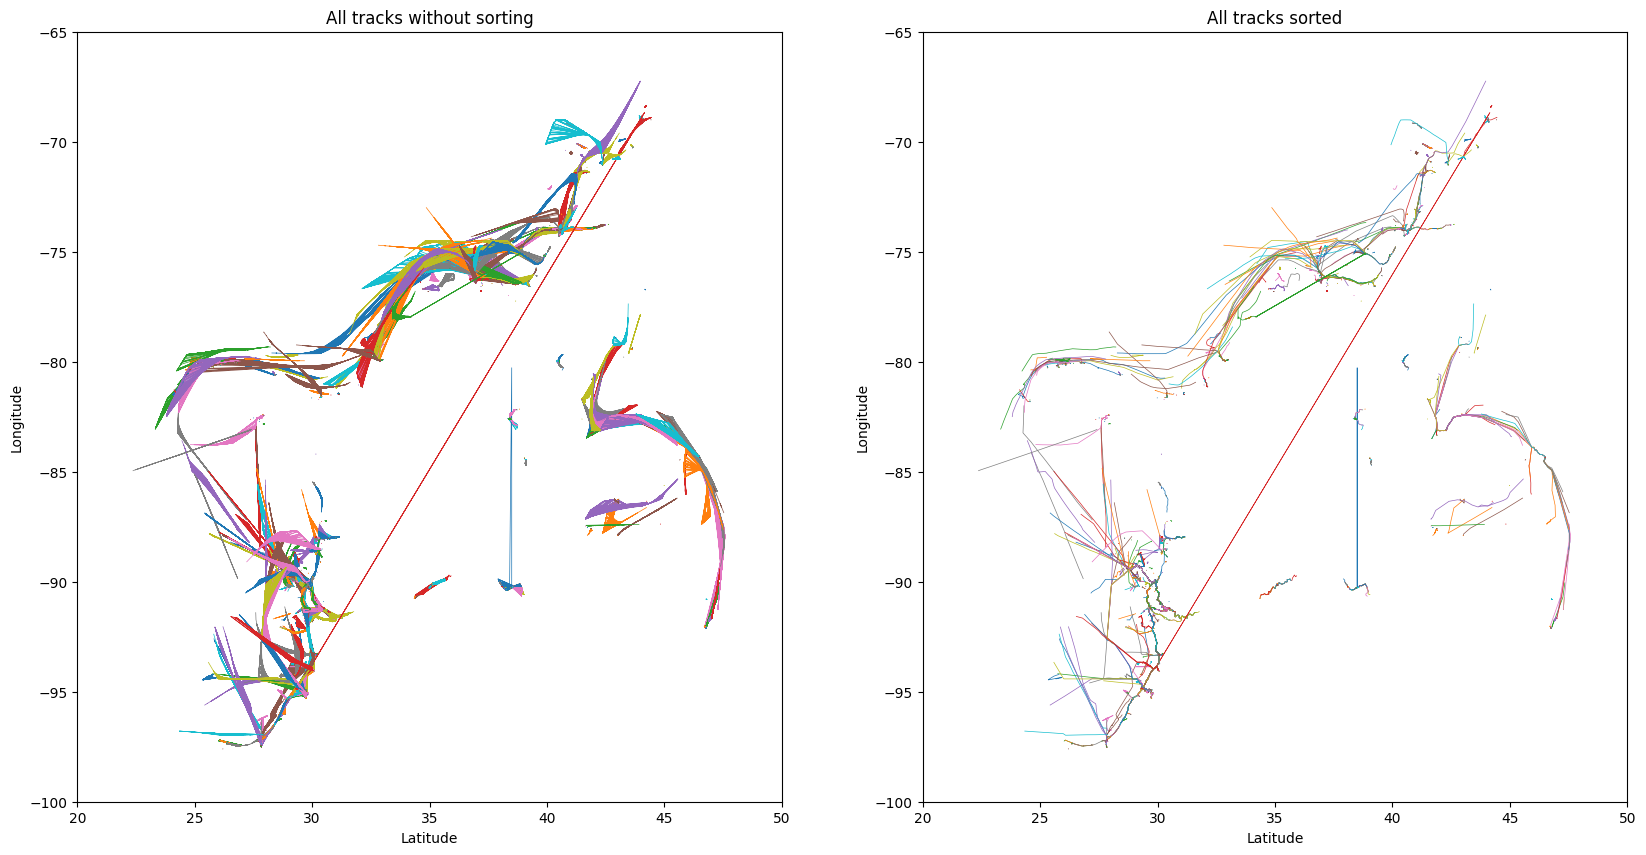

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].set_xlim(20, 50)
ax[1].set_xlim(20, 50)
ax[0].set_ylim(-100, -65)
ax[1].set_ylim(-100, -65)
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Longitude")
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Longitude")
ax[0].set_title("All tracks without sorting")
ax[1].set_title("All tracks sorted")

for g in group:
    if len(g[1]) > 1000:
        ax[0].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
for g in group2:
    if len(g[1]) > 1000:
        ax[1].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
plt.show()

### Plot showing all tracks in an area, points sorted by time

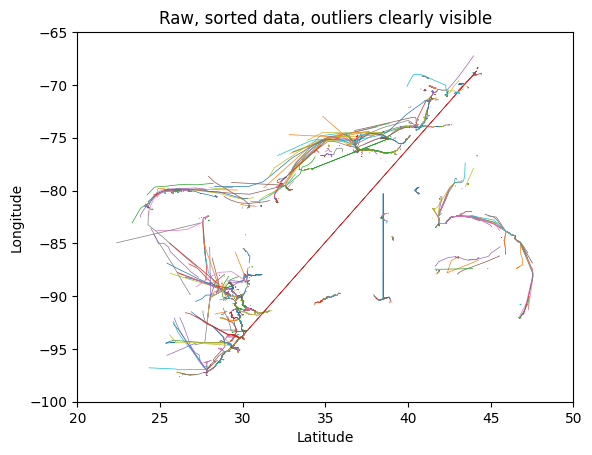

In [19]:
plt.xlim(20, 50)
plt.ylim(-100, -65)
plt.title("Raw, sorted data, outliers clearly visible")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
for g in group2:
    if len(g[1]) > 1000:
        plt.plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
plt.show()

## Plot showing all tracks in an area, points sorted by time, with segmentation

#### Takes ~45 minutes to run

In [238]:
threshold_space = 10

all_subtracks = []

for mmsi in tqdm(mmsis):
    all_subtracks.append(partition(group2.get_group(mmsi), threshold_space))


100%|██████████| 2835/2835 [46:35<00:00,  1.01it/s] 


In [240]:
# save all_subtracks to file
with open("all_subtracks.pkl", "wb") as f:
    pickle.dump(all_subtracks, f)

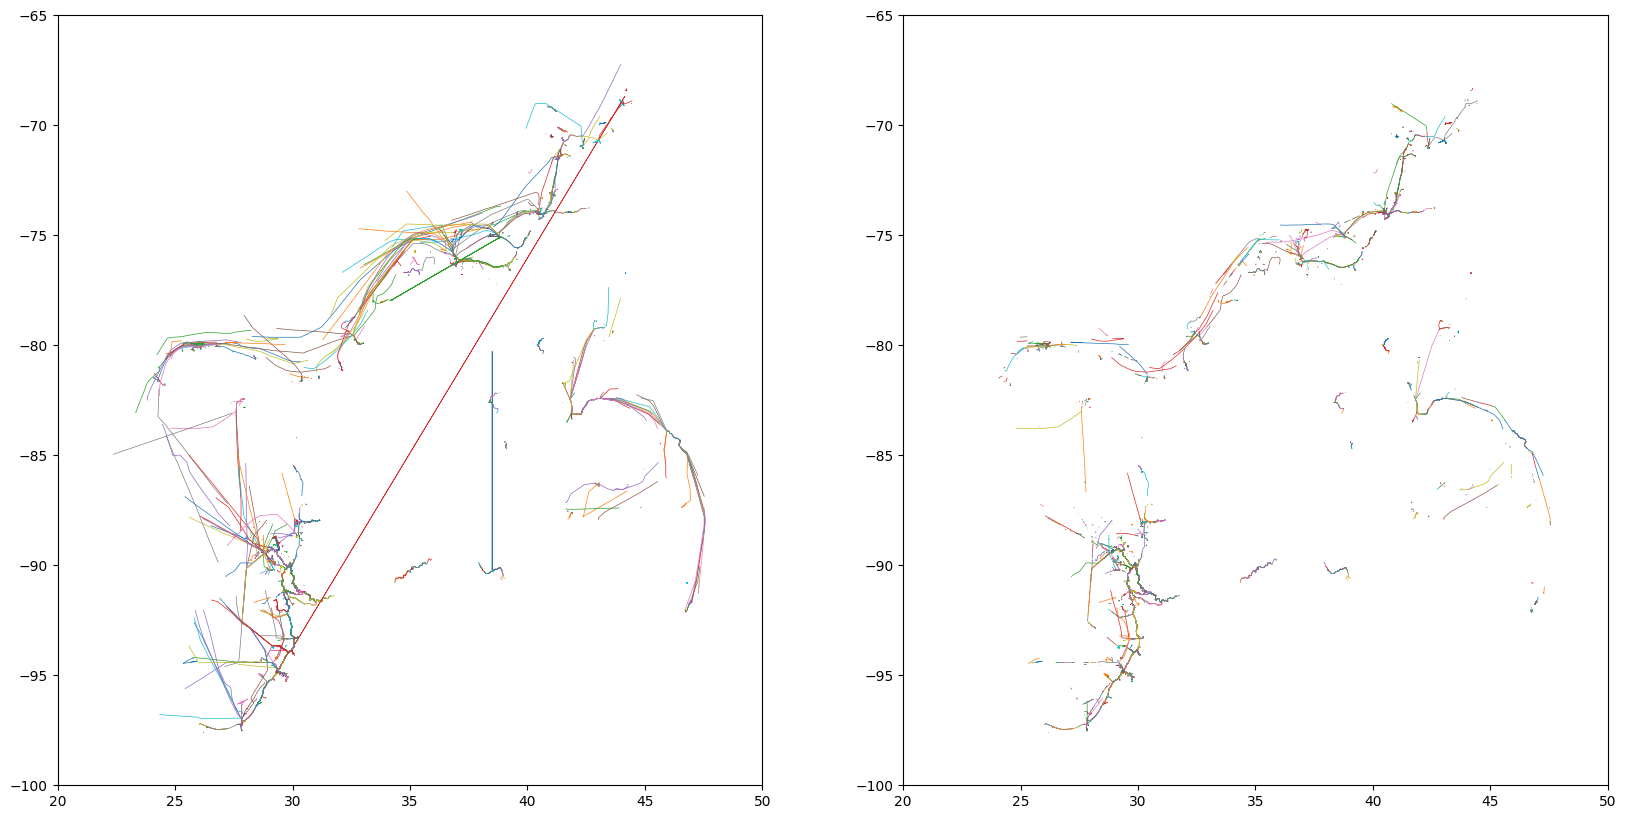

In [239]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].set_xlim(20, 50)
ax[1].set_xlim(20, 50)
ax[0].set_ylim(-100, -65)
ax[1].set_ylim(-100, -65)

for g in group2:
    if len(g[1]) > 1000:
        ax[0].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
for subtrack in all_subtracks:
    for sub in subtrack:
        ax[1].plot(sub['LAT'], sub['LON'], linewidth=0.5)
plt.show()

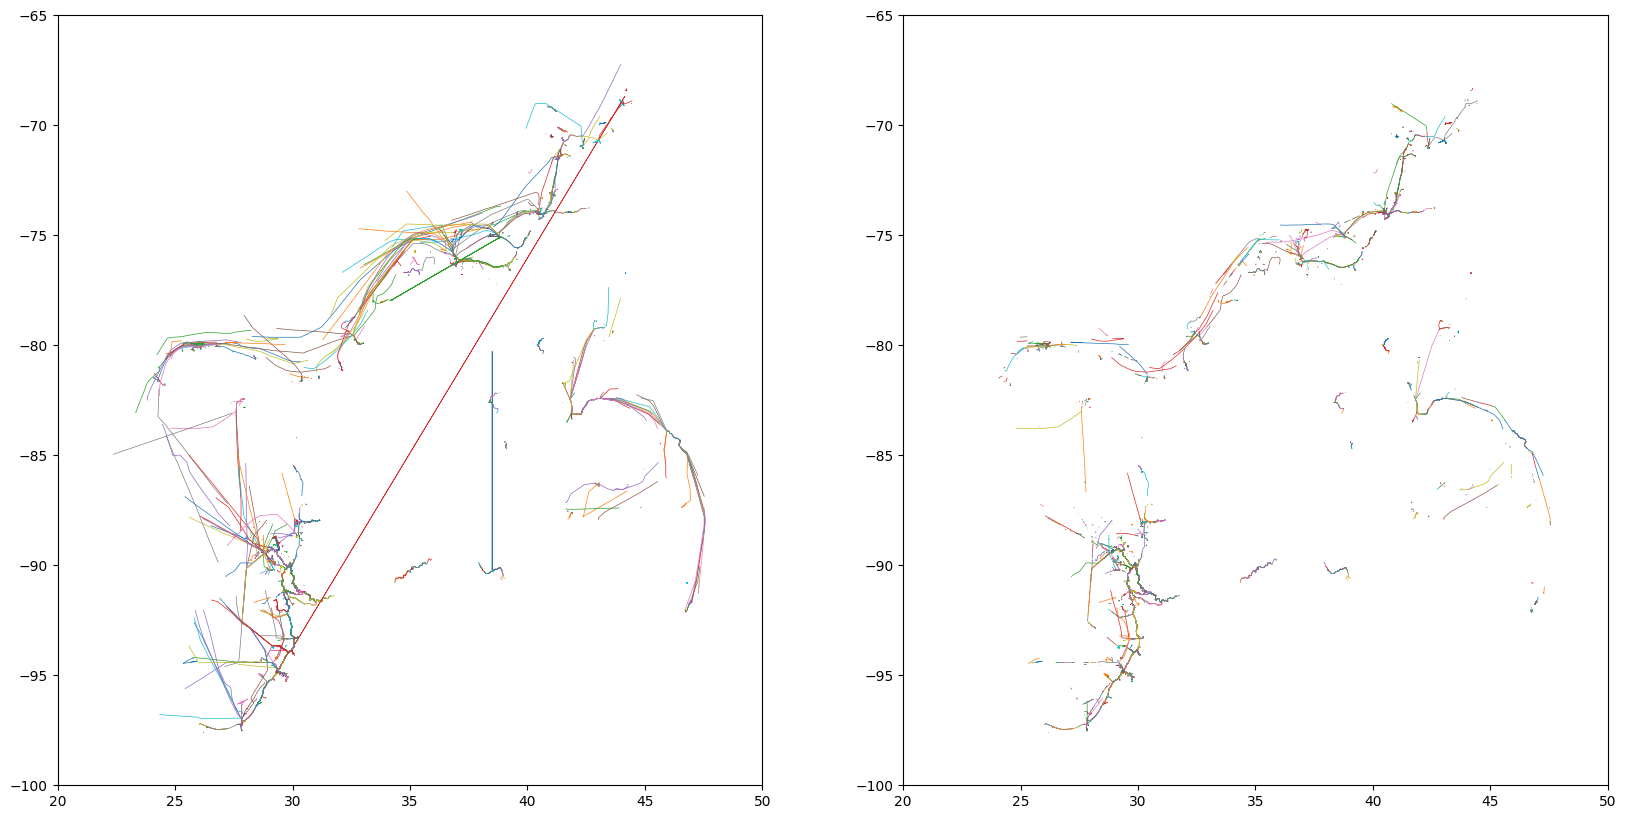

In [241]:
# load all_subtracks from file
with open("all_subtracks.pkl", "rb") as f:
    all_subtracks_loaded = pickle.load(f)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_xlim(20, 50)
    ax[1].set_xlim(20, 50)
    ax[0].set_ylim(-100, -65)
    ax[1].set_ylim(-100, -65)

    for g in group2:
        if len(g[1]) > 1000:
            ax[0].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
    for subtrack in all_subtracks_loaded:
        for sub in subtrack:
            ax[1].plot(sub['LAT'], sub['LON'], linewidth=0.5)
    plt.show()

## Plot showing tracks with possible outliers

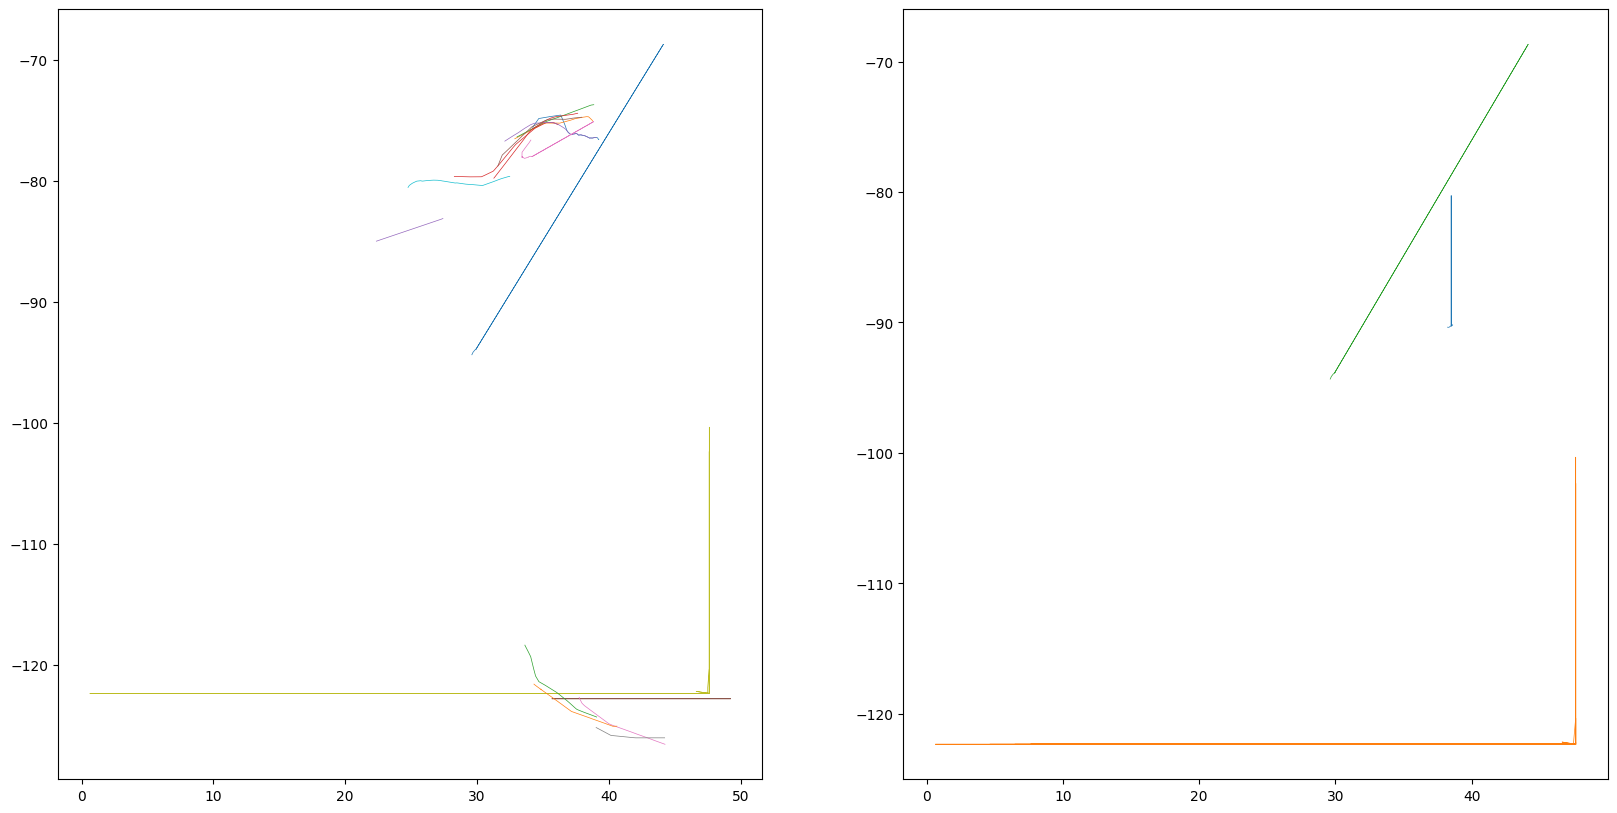

In [ ]:
# plot all tracks of mmsis where the difference between the min and max lat is greater than 30
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# ax[0].set_xlim(20, 50)
# ax[1].set_xlim(20, 50)
# ax[0].set_ylim(-100, -65)
# ax[1].set_ylim(-100, -65)

mmsi_2 = []

for g in group2:
    if len(g[1]) > 1000 and g[1]['LAT'].max() - g[1]['LAT'].min() > 5:
        ax[0].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
    if len(g[1]) > 1000 and g[1]['LON'].max() - g[1]['LON'].min() > 10:
        mmsi_2.append(g[0])
        ax[1].plot(g[1]['LAT'], g[1]['LON'], linewidth=0.5)
# for i, m in enumerate(mmsis):
#     if i % 100 == 0:
#         print(i)
#     subtracks = partition(group2.get_group(m), 15)
#     for subtrack in subtracks:
#         ax[1].plot(subtrack['LAT'], subtrack['LON'], linewidth=0.5)
plt.show()

## Plot showing process of removing outliers

In [230]:
mmsi_2 = [367371510, 368066030]
sub = []
for m in mmsi_2:
    print(m)
    sub.append(partition(group2.get_group(m), 10))

367371510
368066030


In [231]:
associated = []
for m in mmsi_2:
    part = partition(group2.get_group(m), 5)
    associated.append(association(part, 15, 100))

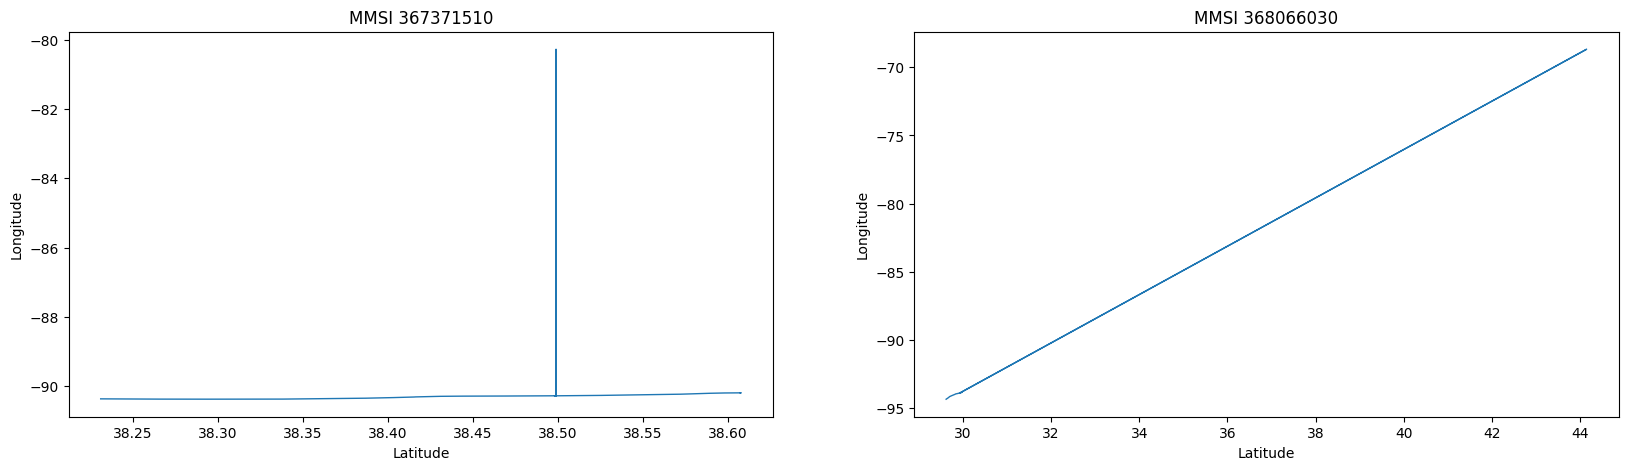

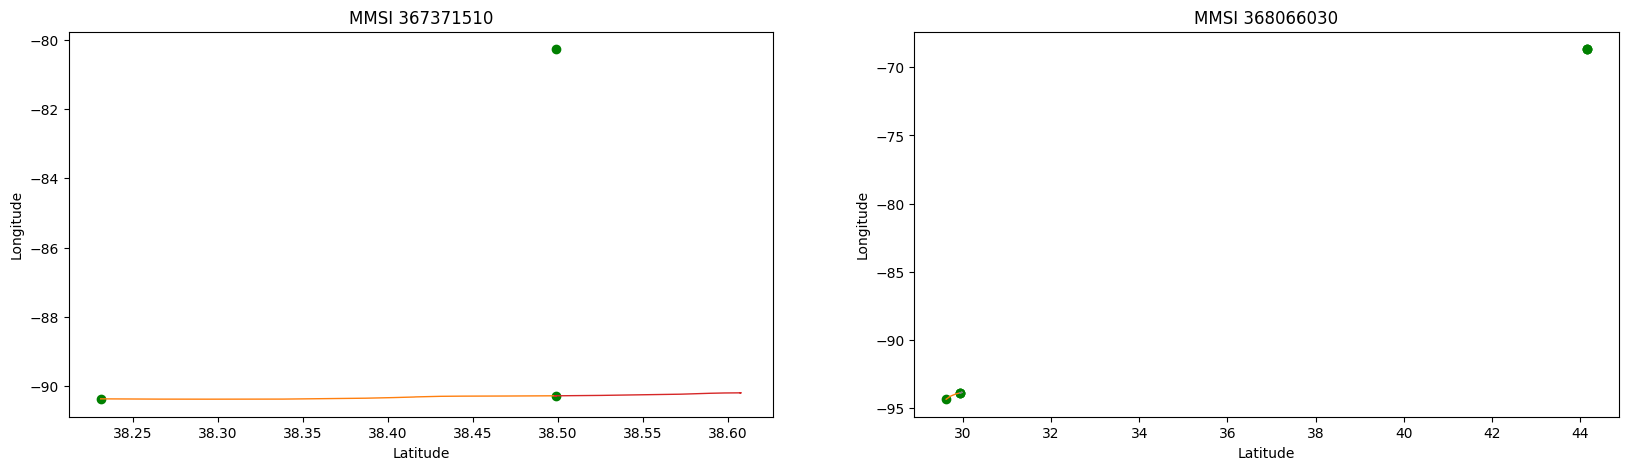

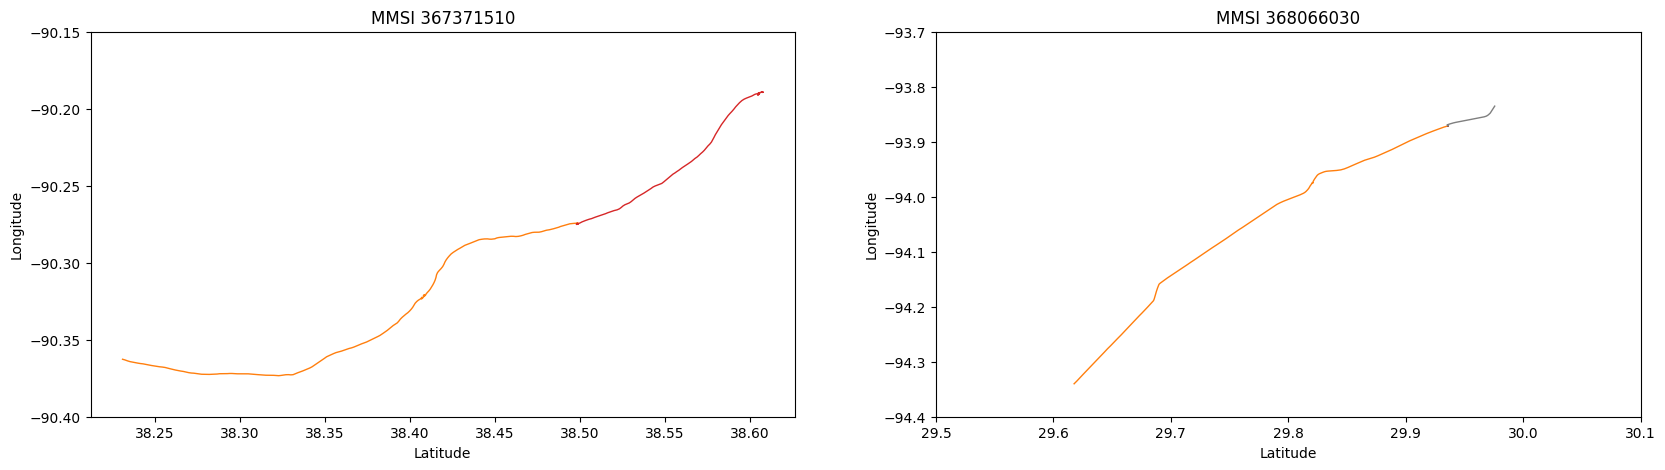

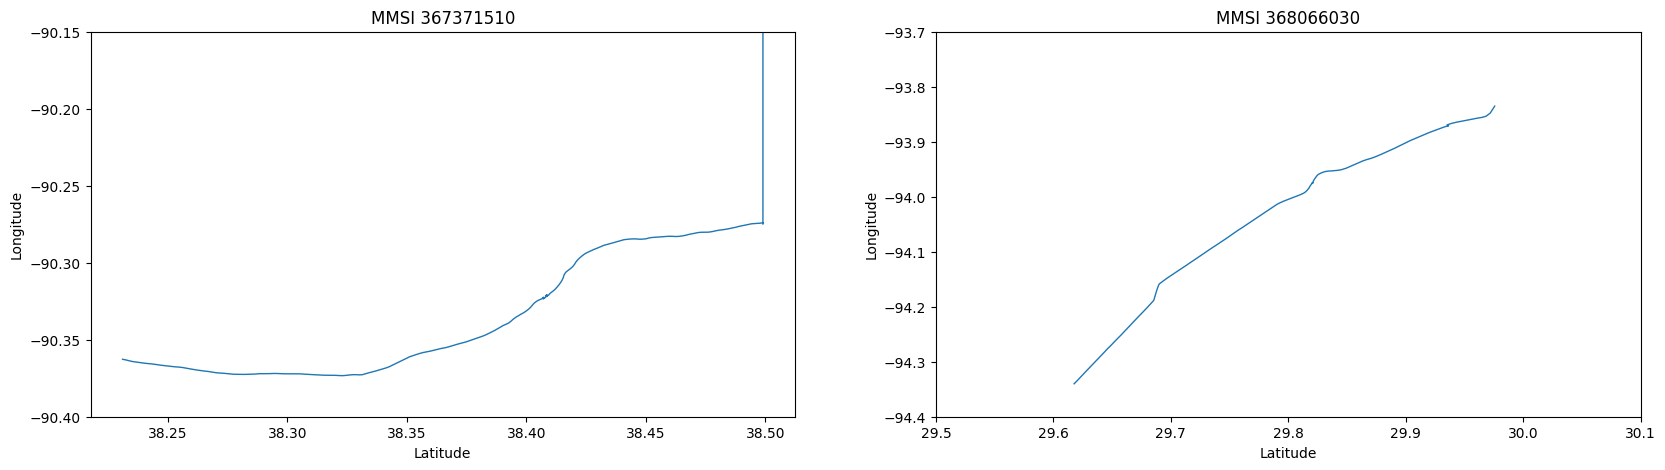

In [232]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i, m in enumerate(mmsi_2):
    ax[i].set_title(f"MMSI {m}")
    ax[i].plot(group2.get_group(m)['LAT'], group2.get_group(m)['LON'], linewidth=1)
    ax[i].set_xlabel("Latitude")
    ax[i].set_ylabel("Longitude")
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i, s in enumerate(sub):
    for st in s:
        ax[i].set_title(f"MMSI {mmsi_2[i]}")
        ax[i].plot(st['LAT'], st['LON'], linewidth=1)
        ax[i].scatter(st['LAT'][:1], st['LON'][:1], color="green")
        ax[i].set_xlabel("Latitude")
        ax[i].set_ylabel("Longitude")
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i, s in enumerate(sub):
    for st in s:
        ax[i].set_title(f"MMSI {mmsi_2[i]}")
        ax[i].plot(st['LAT'], st['LON'], linewidth=1)
ax[0].set_ylim(-90.4, -90.15)
# ax[1].set_xlim(47.4, 48)
# ax[1].set_ylim(-122.5, -122)
# ax[2].set_xlim(29.5, 30.1)
# ax[2].set_ylim(-94.4, -93.7)
ax[1].set_xlim(29.5, 30.1)
ax[1].set_ylim(-94.4, -93.7)
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Longitude")
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Longitude")
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i, s in enumerate(associated):
    for st in s:
        ax[i].set_title(f"MMSI {mmsi_2[i]}")
        ax[i].plot(st['LAT'], st['LON'], linewidth=1)
ax[0].set_ylim(-90.4, -90.15)
# ax[1].set_xlim(47.4, 48)
# ax[1].set_ylim(-122.5, -122)
# ax[2].set_xlim(29.5, 30.1)
# ax[2].set_ylim(-94.4, -93.7)
ax[1].set_xlim(29.5, 30.1)
ax[1].set_ylim(-94.4, -93.7)
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Longitude")
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Longitude")
plt.show()      


## Experiment to get plots using altair

In [31]:
chart = alt.Chart(group2.get_group(368066030)).mark_line().encode(
    x='LAT',
    y='LON'
).interactive()
chart

alt.Chart(...)

In [115]:
chart_1 = alt.Chart(group2.get_group(368066030)).mark_line().encode(
    x='LAT',
    y='LON'
).interactive()

chart_2 = alt.Chart(group2.get_group(367650000)).mark_line().encode(
    x='LAT',
    y='LON'
).interactive()

chart_1 + chart_2

alt.LayerChart(...)

In [6]:
len(data)

7239758

In [105]:
source = data[data['MMSI'].isin(mmsis[:2])]

In [99]:
len(source)

2489

In [106]:
source = source.sort_values("BaseDateTime")
source.head()

MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
757   3669881 2022-01-01 00:00:03  43.26182 -79.06388  0.0  360.0    511.0   
3116  3669882 2022-01-01 00:00:08  42.87710 -78.88665  0.0  360.0    511.0   
2881  3669881 2022-01-01 00:01:14  43.26181 -79.06388  0.0  360.0    511.0   
3341  3669882 2022-01-01 00:01:18  42.87711 -78.88665  0.0  360.0    511.0   
9863  3669881 2022-01-01 00:02:24  43.26181 -79.06389  0.0  360.0    511.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
757         NaN  NaN      NaN         0.0    15.0     0.0    0.0    0.0   
3116        NaN  NaN      NaN         0.0    15.0     0.0    0.0    0.0   
2881        NaN  NaN      NaN         0.0    15.0     0.0    0.0    0.0   
3341        NaN  NaN      NaN         0.0    15.0     0.0    0.0    0.0   
9863        NaN  NaN      NaN         0.0    15.0     0.0    0.0    0.0   

      Cargo TransceiverClass  
757     0.0                A  
3116    0.0                A  
2881    0.0                A  
3341    0.0                A  
9863    0.0                A

In [109]:
source_melt = source.melt(value_vars=['LAT', 'LON'], var_name='MMSI')
#source_melt = source.melt('LAT', var_name='cat', value_name='LON')

In [110]:
source_melt.tail()

MMSI     value
4973  LON -79.06389
4974  LON -78.88665
4975  LON -79.06390
4976  LON -78.88665
4977  LON -79.06390

In [84]:
source['Vessel Number'].unique()

array(['LAT', 'LON'], dtype=object)

In [85]:
len(source)

4978

In [86]:
line = alt.Chart(source).mark_line(interpolate='basis').encode(
    x='LAT:Q',
    y='LON:Q',
    #color='category:N'
)
line

alt.Chart(...)

In [91]:
import altair as alt
import pandas as pd
import numpy as np

np.random.seed(42)
source = pd.DataFrame(
    np.cumsum(np.random.randn(100, 3), 0).round(2),
    columns=['A', 'B', 'C'], index=pd.RangeIndex(100, name='x')
)
source.head()

A     B     C
x                  
0  0.50 -0.14  0.65
1  2.02 -0.37  0.41
2  3.60  0.40 -0.06
3  4.14 -0.07 -0.52
4  4.38 -1.98 -2.25

In [ ]:
source = source.reset_index().melt('x', var_name='category', value_name='y')

# The basic line
line = alt.Chart(source).mark_line(interpolate='basis').encode(
    x='x:Q',
    y='y:Q',
    color='category:N'
)
line

In [90]:
source.head()

x category     y
0  0        A  0.50
1  1        A  2.02
2  2        A  3.60
3  3        A  4.14
4  4        A  4.38

### Generate statistics over all tracks

In [19]:
vessel_types = pd.read_csv("AIS_categories.csv")

categories = {
    r["num"]: r["category"] if r["category"] in [0,2,3,19,12,18] else 21 for _, r in vessel_types.iterrows()
}
categories[np.NaN] = 0
vessel_mapping = dict(zip(vessel_types["num"].to_list(), vessel_types["category"].to_list()))

def category_desc(val):
    """Return description for the category with the indicated integer value"""
    return vessel_types[vessel_types["category"] == val].iloc[0].category_desc

groups = {categories[i]: category_desc(categories[i]) for i in vessel_types.num.unique()}

groups

{0: 'Unknown',
 21: 'Other',
 2: 'Fishing',
 3: 'Towing',
 12: 'Tug',
 18: 'Passenger',
 19: 'Cargo'}

In [20]:
with open("all_subtracks.pkl", "rb") as f:
    allsubtracks = pickle.load(f)

In [21]:
# remove every subtrack[i] in allsubtracks if len(subtrack[i]) < 1
allsubtracks = [[x for x in s if len(x) > 0] for s in allsubtracks if len(s) > 0]
len(allsubtracks)

2835

In [22]:
# create an dataframe with the "mmsi" as index column
stats_df = pd.DataFrame(index = mmsis)
# add a column with a list containing the vessel group of each mmsi
stats_df['vessel_type'] = [s[0].iloc[0]['VesselType'] for s in allsubtracks]
stats_df['vessel_group'] = stats_df['vessel_type'].replace(categories).replace(groups)
# add a column with the number of subtracks for each mmsi
stats_df['#subtracks'] = [len(s) for s in allsubtracks]
# add a column with the mean length of each subtrack for each mmsi
stats_df['mean_length'] = [np.mean([len(x) for x in s]) for s in allsubtracks]
# add a column with the median length of each subtrack for each mmsi
stats_df['median_length'] = [np.median([len(x) for x in s]) for s in allsubtracks]
# add a column with the start time of the first subtrack for each mmsi
stats_df['start_time'] = [s[0].iloc[0]['BaseDateTime'] for s in allsubtracks]
# add a column with the end time of the last subtrack for each mmsi
stats_df['end_time'] = [s[-1].iloc[-1]['BaseDateTime'] for s in allsubtracks]
# add a column with the total time span of all subtracks for each mmsi
# stats_df['travel_time'] = [s[-1].iloc[-1]['BaseDateTime'] - s[0].iloc[0]['BaseDateTime'] for s in allsubtracks]
# add a column with a list of list containing the latitudes of all subtracks for each mmsi
# stats_df['lats'] = [[x['LAT'].tolist() for x in s] for s in allsubtracks]
# add a column with a list of list containing the longitudes of all subtracks for each mmsi
# stats_df['lons'] = [[x['LON'].tolist() for x in s] for s in allsubtracks]

In [13]:
stats_df.to_csv("stats_df.csv")

In [14]:
stats_df.head()

vessel_type vessel_group  #subtracks  mean_length  median_length  \
3669881            0.0      Unknown           1  1241.000000         1241.0   
3669882            0.0      Unknown           1  1248.000000         1248.0   
3669884            0.0      Unknown           1  1218.000000         1218.0   
12345678          32.0       Towing           1  1193.000000         1193.0   
122292919         50.0        Other          23    54.173913            1.0   

                   start_time            end_time  
3669881   2022-01-01 00:00:03 2022-01-01 23:59:55  
3669882   2022-01-01 00:00:08 2022-01-01 23:59:29  
3669884   2022-01-01 00:00:07 2022-01-01 23:59:58  
12345678  2022-01-01 00:00:02 2022-01-01 23:58:52  
122292919 2022-01-01 00:00:02 2022-01-01 23:58:54

In [28]:
brush = alt.selection_interval()
vessel_group_selection = alt.selection_point(fields=['vessel_group'], bind='legend')

heatmap = alt.Chart(stats_df).mark_rect().encode(
    x=alt.X('#subtracks:Q', bin=True, title="Number of subtracks (binned)"),
    y=alt.Y('vessel_group:N', title="Vessel Group"),
    color=alt.Color('count(#subtracks):Q', scale=alt.Scale(scheme='Blues')),
    opacity=alt.condition(vessel_group_selection, alt.value(1), alt.value(0.0)),
    tooltip=['vessel_group', 'count(#subtracks)']
).properties(
    height=300
).add_params(
    brush,
    vessel_group_selection
)
heatmap

alt.Chart(...)

In [29]:
bars1 = alt.Chart(stats_df).mark_bar().encode(
    x=alt.X('vessel_group:N', title="Vessel Group"),
    y=alt.Y('count(vessel_group):Q', title="Number of Vessels").scale(type='log'),
    color=alt.Color('vessel_group:N'),
    tooltip=['vessel_group:N', 'count(vessel_group):Q'],
    opacity=alt.condition(vessel_group_selection, alt.value(1), alt.value(0.2))
).properties(
    height=300
).add_params(
    vessel_group_selection
).transform_filter(
    brush
)

bars2 = alt.Chart(stats_df).mark_bar().encode(
    x=alt.X('vessel_group:N', title="Vessel Group"),
    y=alt.Y('sum(#subtracks):Q', title="Number of Subtracks").scale(type='log'),
    color=alt.Color('vessel_group:N'),
    tooltip=['vessel_group:N', 'sum(#subtracks):Q'],
    opacity=alt.condition(vessel_group_selection, alt.value(1), alt.value(0.2))
).properties(
    height=300
).add_params(
    vessel_group_selection
).transform_filter(
    brush
)

bars3 = alt.Chart(stats_df).mark_bar().encode(
    x=alt.X('vessel_group:N', title="Vessel Group"),
    y=alt.Y('mean(mean_length):Q', title="Mean Number of Points per Subtrack"),
    color=alt.Color('vessel_group:N'),
    tooltip=['vessel_group:N', 'mean(mean_length):Q'],
    opacity=alt.condition(vessel_group_selection, alt.value(1), alt.value(0.2))
).properties(
    height=300,
).add_params(
    vessel_group_selection
).transform_filter(
    brush
)

bars = bars1 | bars2 | bars3
bars 

alt.HConcatChart(...)

In [17]:
bars.save("ais_data_quality_barchart.json")

In [30]:
dashbord = heatmap & bars
dashbord

alt.VConcatChart(...)

In [31]:
dashbord.save("ais_data_quality_dashboard.json")

In [33]:
len(stats_df)

2835

In [23]:
alt.__version__

'5.0.0rc1'